In [1]:
import os
import torch

from torchinfo import summary

import torch
import torch.nn as nn

import torch.optim as optim
from torch.optim import SGD
import torch.nn.functional as F

from mobiface_like_v2 import MobiFace

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler

import numpy as np
from sklearn.metrics import roc_curve
from itertools import islice
from facenet_pytorch import InceptionResnetV1

from backbone import get_model
import model


import random

MobiFace(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwise_conv): DepthwiseSeparableConv2d(
    (depthwise_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (pointwise_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): PReLU(num_parameters=1)
  )
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bottleneck_block1): BottleneckBlock(
    (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): PReLU(num_parameters=1)
    (depthwise_conv): DepthwiseSeparableConv2d(
      (depthwise_conv): Conv2d(32, 32, kernel_size=(3, 3), stri

c:\Users\mathe\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set a random seed for reproducibility
seed = 42
torch.manual_seed(seed)

# If using GPU, also set the seed for GPU
torch.cuda.manual_seed_all(seed)


In [3]:
import torch
import torchvision.models as models



In [4]:
#student =  torch.load("KD_full_mobiFace_like_feature_v2_2.pth") 

student =  torch.load("KD_full_mobiFace_like_feature_v2_2.pth")   #torch.load("KD_full_mobiFace_like_nologits_v2_4.pth")

#checkpoint_path = 'checkpoint_epoch_kd_v2_2_featureOnly_3.pt'  
#checkpoint = torch.load(checkpoint_path)

# Load student model state dict
#student.load_state_dict(checkpoint['student_model_state_dict'])


#student = torch.load("KD_full_mobiFace_like_test.pth")



In [5]:
# Load a pre-trained ResNet model
teacher_v3 = model.Backbone(50, 0.6, 'ir_se').cuda()
teacher_state_dict = torch.load('model_ir_se50.pth')
teacher_v3.load_state_dict(teacher_state_dict)


<All keys matched successfully>

In [6]:

# Set the model to evaluation mode
teacher_v3.eval()

Backbone(
  (input_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=64)
  )
  (output_layer): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.6, inplace=False)
    (2): Flatten()
    (3): Linear(in_features=25088, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (body): Sequential(
    (0): bottleneck_IR_SE(
      (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
      (res_layer): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): PReLU(num_parameters=64)
        (3)

In [7]:
summary(teacher_v3, (1,3,112,112))

Layer (type:depth-idx)                             Output Shape              Param #
Backbone                                           [1, 512]                  --
├─Sequential: 1-1                                  [1, 64, 112, 112]         --
│    └─Conv2d: 2-1                                 [1, 64, 112, 112]         1,728
│    └─BatchNorm2d: 2-2                            [1, 64, 112, 112]         128
│    └─PReLU: 2-3                                  [1, 64, 112, 112]         64
├─Sequential: 1-2                                  [1, 512, 7, 7]            --
│    └─bottleneck_IR_SE: 2-4                       [1, 64, 56, 56]           --
│    │    └─MaxPool2d: 3-1                         [1, 64, 56, 56]           --
│    │    └─Sequential: 3-2                        [1, 64, 56, 56]           74,560
│    └─bottleneck_IR_SE: 2-5                       [1, 64, 56, 56]           --
│    │    └─MaxPool2d: 3-3                         [1, 64, 56, 56]           --
│    │    └─Sequential: 3-4

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
student.to(device)

MobiFace(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (depthwise_conv): DepthwiseSeparableConv2d(
    (depthwise_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (pointwise_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): PReLU(num_parameters=1)
  )
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bottleneck_block1): BottleneckBlock(
    (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): PReLU(num_parameters=1)
    (depthwise_conv): DepthwiseSeparableConv2d(
      (depthwise_conv): Conv2d(32, 32, kernel_size=(3, 3), stri

In [10]:
teacher_v3.to(device)


Backbone(
  (input_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=64)
  )
  (output_layer): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.6, inplace=False)
    (2): Flatten()
    (3): Linear(in_features=25088, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (body): Sequential(
    (0): bottleneck_IR_SE(
      (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
      (res_layer): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): PReLU(num_parameters=64)
        (3)

In [11]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [12]:
# directory for test
root_dir= "C:\\Users\\mathe\\OneDrive\\Área de Trabalho\\master\\TFM\\dataset\\faces_webface_112x112\\images"


batch_size = 64

# Create ImageFolder dataset
dataset = datasets.ImageFolder(root=root_dir, transform=transform)

# Number of images for testing
num_test_images = 2000

# Total number of images
total_images = len(dataset)

# Indices of images for testing
test_indices = random.sample(range(total_images), num_test_images)

# Remaining indices for validation and training
remaining_indices = set(range(total_images)) - set(test_indices)


# Split remaining indices into validation and training sets
remaining_indices = list(remaining_indices)
random.shuffle(remaining_indices)


# Define the sizes of validation and training sets
val_size = int(0.20 * len(remaining_indices))
train_size = len(remaining_indices) - val_size

# Indices for validation and training sets
val_indices = remaining_indices[:val_size]
train_indices = remaining_indices[val_size:]


# Create Subset datasets
test_dataset = Subset(dataset, test_indices)
val_dataset = Subset(dataset, val_indices)
train_dataset = Subset(dataset, train_indices)

# Create DataLoader for training, validation, and testing
batch_size = 1  # Set batch size to 1 since we are loading images one by one
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)



In [13]:
inputs_total = []
labels_total = []
for inputs, labels in islice(train_loader,32):
    inputs, labels = inputs.to(device), labels.to(device)
    labels_total.append(labels)
    inputs_total.append(inputs)

In [14]:
teacher_v3.eval()
def cosine_similarity(embeddings1, embeddings2):
    dot_product = torch.dot(embeddings1, embeddings2)
    norm_embeddings1 = torch.norm(embeddings1)
    norm_embeddings2 = torch.norm(embeddings2)
    return dot_product / (norm_embeddings1 * norm_embeddings2)

In [15]:
cosine_similarity(teacher_v3(inputs_total[0])[0],student(inputs_total[0])[0])

tensor(0.1342, device='cuda:0', grad_fn=<DivBackward0>)

In [16]:
cosine_similarity(teacher_v3(inputs_total[0])[0],teacher_v3(inputs_total[0])[0])

tensor(1.0000, device='cuda:0', grad_fn=<DivBackward0>)

In [17]:
teacher= student #teacher_v3  

In [18]:



embeddings = []  # List to store embeddings
labels_list = []  # List to store labels
comparison_similarity = []

teacher.eval()
for images,labels in test_loader:
    with torch.no_grad():
        outputs = teacher(images.to(device))
    embeddings.append(outputs.to(device))
    labels_list.append(labels.to(device))


embeddings = torch.cat(embeddings, dim=0)
labels_list = torch.cat(labels_list, dim=0)

# Prepare labels for pairwise similarity scores (1 for same person, 0 for different people)
pairwise_labels = []
comparisons_label = []
for i, (images1, label1) in enumerate(test_loader):
    for j, (images2, label2) in enumerate(test_loader):
        if j > i:  # Only consider pairs where j > i to avoid duplicate pairs and pairs with the same image
            if label1 == label2:
                pair_label = 1  # Same person
            else:
                pair_label = 0  # Different people
            pairwise_labels.append(pair_label)
            comparisons_label.append([pair_label,label1,label2])

# Convert pairwise labels to a tensor
pairwise_labels_tensor = torch.tensor(pairwise_labels, device=device)


similarities = []
for i in range(len(embeddings)):
    for j in range(i+1, len(embeddings)):
        similarity = cosine_similarity(embeddings[i], embeddings[j])
        comparison_similarity.append([similarity,labels_list[i],labels_list[j]])
        similarities.append(similarity)

similarities_tensor = torch.tensor(similarities, device=device)

In [19]:
# Compute ROC curve

#fpr, tpr, thresholds = roc_curve(pairwise_labels_tensor.cpu().numpy(), similarities_tensor.cpu().numpy())
fpr, tpr, thresholds = roc_curve(pairwise_labels_tensor.cpu().numpy(), similarities_tensor.cpu().numpy())


# Move thresholds to CUDA

thresholds_tensor = torch.tensor(thresholds, device=device)


# Convert fpr and tpr to PyTorch tensors

fpr_tensor = torch.tensor(fpr, device=device)
tpr_tensor = torch.tensor(tpr, device=device)


# Calculate EER
eer_threshold = thresholds_tensor[torch.argmin(torch.abs(fpr_tensor - (1 - tpr_tensor)))]
eer = (fpr_tensor[torch.argmin(torch.abs(fpr_tensor - (1 - tpr_tensor)))] + (1 - tpr_tensor)[torch.argmin(torch.abs(fpr_tensor - (1 - tpr_tensor)))]) / 2

print("Equal Error Rate (EER):", eer)

Equal Error Rate (EER): tensor(0.0763, device='cuda:0', dtype=torch.float64)


In [20]:
thresholds_tensor

tensor([    inf,  0.8899,  0.6511,  ..., -0.2149, -0.2149, -0.4105],
       device='cuda:0')

In [21]:
len(np.unique(np.array(labels_list.cpu())))

1635

In [22]:
eer_threshold 

tensor(0.1902, device='cuda:0')

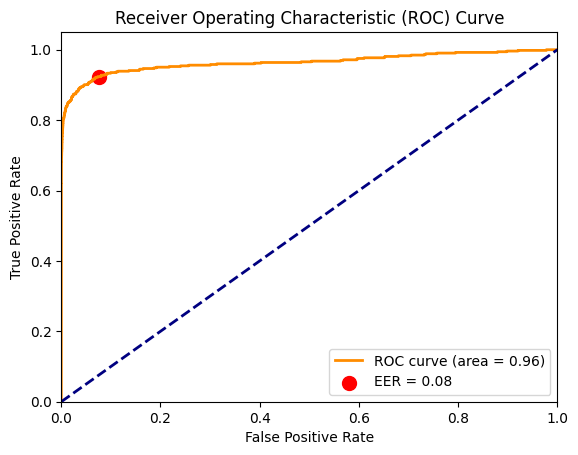

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot EER point
plt.scatter(fpr_tensor[torch.argmin(torch.abs(fpr_tensor.cpu() - (1 - tpr_tensor.cpu())))].cpu(), 
            tpr_tensor[torch.argmin(torch.abs(fpr_tensor.cpu() - (1 - tpr_tensor.cpu())))].cpu(), 
            s=100, c='red', marker='o', label='EER = %0.2f' % eer)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()